In [1]:
import sys, os
from pathlib import Path

# find repo root (parent of "experiments") and add to sys.path
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

from eap_fit_hh.inference import EKFTrainer
from eap_fit_hh.utils import compute_comp_xyz, distance, plot_cond_params, compute_eap, build_axial_matrix, build_eap_M, get_surface_areas

In [2]:
import jaxley as jx
from jaxley.channels import HH
import networkx as nx
from jaxley.io.graph import swc_to_graph, make_jaxley_compatible, from_graph, to_graph
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
tf = tfp.tf2jax
tfd = tfp.distributions

In [3]:
ncomps_per_branch = 10
nbranches = 1
n_nodes = 2*nbranches
ncomps = nbranches * ncomps_per_branch
comp = jx.Compartment()
cell = jx.Branch(comp, ncomp=ncomps_per_branch)

cell.insert(HH())

cell.set("HH_eNa", 53.0)
cell.set("HH_eK", -107.0)
cell.set("HH_eLeak", -88.5188)
cell.set("v", -88.5188)
cell.set("radius",2.)
cell.set("axial_resistivity", 150.)

# different param values for each gp
cell.set("HH_gNa",  0.12)
cell.set("HH_gK", 0.02)
cell.set("HH_gLeak", 0.0003)
cell.set("length",24.0)

true_cell_positions = compute_comp_xyz(cell)

cell.init_states()

In [4]:
l = 6
x = jnp.array([jnp.arange(jnp.min(true_cell_positions[:,0]), jnp.max(true_cell_positions[:,0])+1, 6.)[0]])
y = jnp.array([0.])
z = jnp.array([5.])
n_points = len(x)
grid = jnp.dstack(jnp.meshgrid(x, y, z)).reshape((n_points, 3))

true_distances = distance(grid, true_cell_positions) # in um
true_distances_CM = true_distances * 10**(-4)

In [5]:
print(n_points)

1


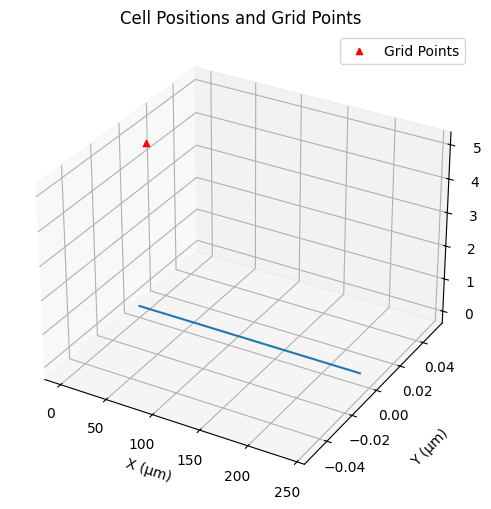

In [6]:
# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments with lines
colors = plt.cm.tab10.colors
cell.vis(ax=ax, color=colors[0])

# Plot grid points
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], c='r', marker='^', label='Grid Points')

# Labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.set_title("Cell Positions and Grid Points")
ax.legend()

In [7]:
dt = 0.025  # ms
t_max = 20.0
times = jnp.arange(0, t_max+2*dt, dt)
n_timesteps = len(times)
current = jx.step_current(i_delay=0.0, i_dur=20., i_amp=1.5, delta_t=dt, t_max=t_max)
cell.comp(0).stimulate(current)

cell.record("v")
cell.record("HH_m")
cell.record("HH_n")
cell.record("HH_h")
cell.record("i_HH")

true_outputs = jx.integrate(cell)

Added 1 external_states. See `.externals` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.
Added 10 recordings. See `.recordings` for details.


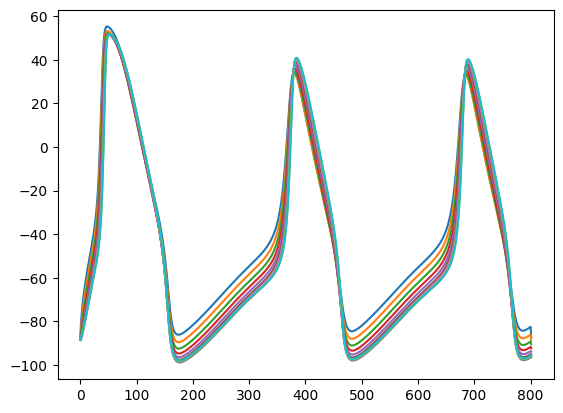

In [8]:
for i in range(ncomps):
    plt.plot(true_outputs[i,:])

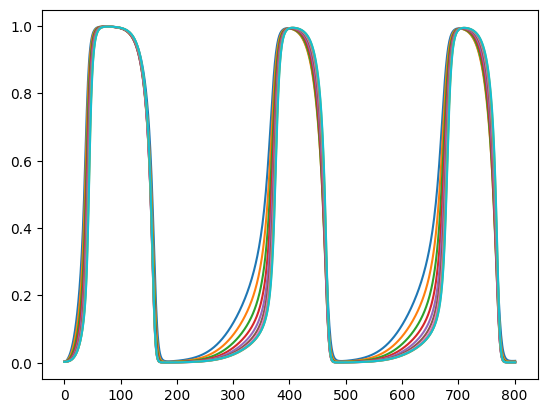

In [9]:
for i in range(ncomps):
    plt.plot(true_outputs[1*ncomps+i,:])

In [10]:
A = build_axial_matrix(cell)
padded_current = jnp.concatenate([jnp.array([0.]),current])
M = build_eap_M(A, true_distances_CM, 300)
v = true_outputs[:ncomps]
extr_voltage = compute_eap(v, M, padded_current, 0, true_distances_CM, 300)
emissions_EAP = extr_voltage  + tfd.Normal(0,0.001).sample((n_points, n_timesteps), seed=random.PRNGKey(1))

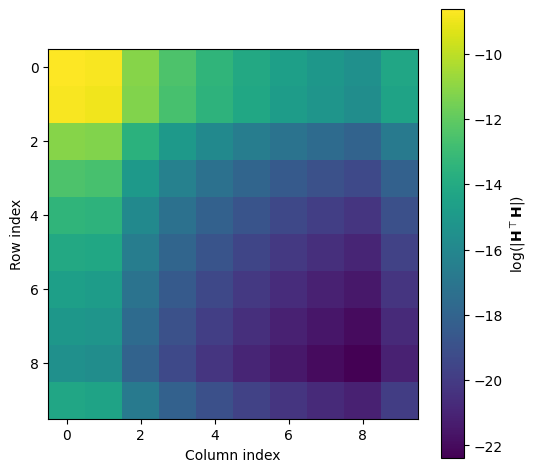

In [11]:
plt.figure(figsize=(5.5, 5.))
im = plt.imshow(jnp.log(jnp.abs(M.T@M)), origin='upper', aspect='equal')  # top-left is [0,0]
cb = plt.colorbar(im)
cb.set_label(r'$\log(|\mathbf{H}^\top \mathbf{H}|)$')

# Put ticks at integer indices so it’s obvious which cell is which

# Draw a box around the top-left (row 0, col 0) cell
ax = plt.gca()

# Optional: label that cell

plt.xlabel('Column index')
plt.ylabel('Row index')
plt.tight_layout()

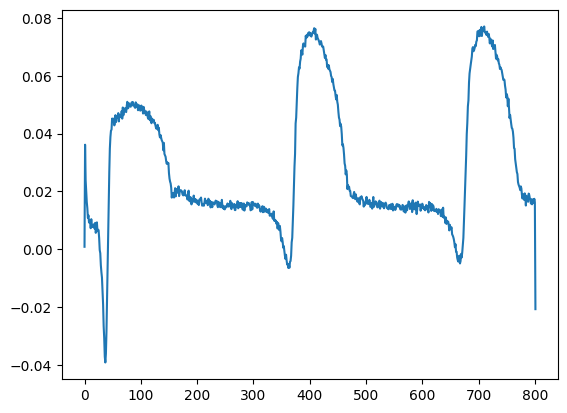

In [11]:
for i in range(len(emissions_EAP)):
    plt.plot(emissions_EAP[i])

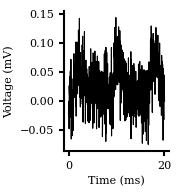

In [12]:
emissions_EAP = extr_voltage+tfd.Normal(0,0.03).sample((n_points, n_timesteps), seed=random.PRNGKey(0))

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5/3, 2))  # Set figure size (width, height in inches)

    plt.plot(times, emissions_EAP[0], color='black', linewidth=0.8)  # Plot single EAP trace

    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")

    plt.tight_layout()
    plt.savefig("eap_trace_30.svg")

In [14]:
HH_params = ['HH_gNa', 'HH_gK', 'HH_gLeak']

In [15]:
dynamics_std = {'v': 0.0001, 'HH_n': 0.00001, 'HH_m': 0.00001, 'HH_h': 0.00001, 'i_HH': 0.01}

In [16]:
Trainer = EKFTrainer(cell = cell,
                     trainable_params = HH_params,
                     dynamics_std = dynamics_std,
                     dt = dt,
                     grid = grid,
                     extracellular_resistivity = 300)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
['HH_gNa', 'HH_gK', 'HH_gLeak']
['HH_gNa', 'HH_gK', 'HH_gLeak']


In [17]:
HH_bounds = {"HH_gLeak": (0.00005, 0.0005),
          "HH_gNa": (0.05, 0.12),
          "HH_gK": (0.005, 0.05)}

init_cond_params = Traineurips pneuripneurjakob macke neurips openreviejakob macke open review neurips
scsacsac AScasner.sample_cond_params(bounds = HH_bounds, key = 3)

SyntaxError: invalid syntax (2576105919.py, line 5)

In [ ]:
init_cond_params

In [ ]:
out = Trainer.train(data = (emissions_EAP.T, current),
            init_cond_params = init_cond_params,
            obs_std = 0.001,
            lr = 0.1,
            num_epochs = 200,
            output = ['cond_params'],
            diagonal = "bloc-diagonal")

In [ ]:
# outs 
# for i in range(40):
#     emissions_EAP = extr_voltage + tfd.Normal(0,0.001).sample((n_points, n_timesteps), seed=random.PRNGKey(i))
#     out = Trainer.train(data = (emissions_EAP.T, current),
#             init_cond_params = init_cond_params,
#             obs_std = 0.001,
#             lr = 0.1,
#             num_epochs = 300,
#             output = ['cond_params'],
#             diagonal = "db")
#     outs = out.append(out)

In [ ]:
inferred_params, true_params = out["cond_params"], Trainer.ref_cond_params
plot_cond_params(params = inferred_params, true_params = true_params)

### Analysis of observation variance 

In [ ]:
import pickle
with open("single_branch_0.001.pkl", "rb") as f:
    data = pickle.load(f)
    outs_001 = data["outs"]
    
with open("single_branch_0.01.pkl", "rb") as f:
    data = pickle.load(f)
    outs_01 = data["outs"]
    
with open("single_branch_0.03.pkl", "rb") as f:
    data = pickle.load(f)
    outs_03 = data["outs"]

Plot individual traces

In [ ]:
true_params = Trainer.ref_cond_params
from jax.tree_util import tree_map
idx = 40
inferred_params = tree_map(lambda x: x[idx], outs)
plot_cond_params(params = inferred_params, true_params = true_params)

Plot 1 parameter histogram

In [ ]:
final_gK_001 = outs_001['HH_gLeak'][:40,-1]
final_gL_01 = outs_01['HH_gLeak'][jnp.r_[0:30, 31:41] ,-1]
final_gLeak_03 = outs_03['HH_gLeak'][:40,-1]

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5/3, 1.5))

    # Plot histograms
    ax.hist(final_gLeak_03, bins=20, alpha=0.3, label='$\sigma_o=30 \mu V$')

    ax.hist(final_gLeak_01, bins=20, alpha=0.6, label='$\sigma_o=10 \mu V$')

    ax.hist(final_gLeak_001, color='red', bins=20, alpha=0.9, label='$\sigma_o=1 \mu V$')

    # Add true value line
    ax.axvline(0.0003, color='black', linestyle='--', label='True value')

    ax.axvline(float(jnp.mean(final_gLeak_03)), color='blue', linestyle=':', linewidth=1.5)
    ax.axvline(float(jnp.mean(final_gLeak_01)), color='orange', linestyle=':', linewidth=1.5)
    ax.axvline(float(jnp.mean(final_gLeak_001)), color='red', linestyle=':', linewidth=1.5)

    # Labels
    ax.set_xlabel("$g_{L}$ (S/cm²)")
    ax.set_ylabel("Frequency")
    ax.legend()
    fig.tight_layout()
    plt.savefig("different_obs_gL.svg")

Plot histogram for all parameters

In [ ]:
final_gLeak_001 = outs_001['HH_gLeak'][:40,-1]
final_gLeak_01 = outs_01['HH_gLeak'][jnp.r_[0:30, 31:41] ,-1]
final_gLeak_03 = outs_03['HH_gLeak'][:40,-1]

final_gNa_001 = outs_001['HH_gNa'][:40,-1]
final_gNa_01 = outs_01['HH_gNa'][jnp.r_[0:30, 31:41] ,-1]
final_gNa_03 = outs_03['HH_gNa'][:40,-1]

final_gK_001 = outs_001['HH_gK'][:40,-1]
final_gK_01 = outs_01['HH_gK'][jnp.r_[0:30, 31:41] ,-1]
final_gK_03 = outs_03['HH_gK'][:40,-1]

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.5, 1.5))
    
    # Your defined colors
    color_2 = "#c6dbef"  # light blue
    color_1 = "#ffbb78"  # orange
    color_0 = "red"      # red

    # Plot histograms in reverse order
    axes[0].hist(final_gLeak_03, bins=20, alpha=1.0, color=color_2, label='$\sigma_o=30\mu V$')
    axes[0].hist(final_gLeak_01, bins=20, alpha=1.0, color=color_1, label='$\sigma_o=10\mu V$')
    axes[0].hist(final_gLeak_001, bins=20, alpha=1.0, color=color_0, label='$\sigma_o=1\mu V$')

    axes[1].hist(final_gK_03, bins=20, alpha=1.0, color=color_2, label='$\sigma_o=30\mu V$')
    axes[1].hist(final_gK_01, bins=20, alpha=1.0, color=color_1, label='$\sigma_o=10\mu V$')
    axes[1].hist(final_gK_001, bins=20, alpha=1.0, color=color_0, label='$\sigma_o=1\mu V$')

    axes[2].hist(final_gNa_03, bins=20, alpha=1.0, color=color_2, label='$\sigma_o=30\mu V$')
    axes[2].hist(final_gNa_01, bins=20, alpha=1.0, color=color_1, label='$\sigma_o=10\mu V$')
    axes[2].hist(final_gNa_001, bins=20, alpha=1.0, color=color_0, label='$\sigma_o=1\mu V$')

    # True value lines
    axes[0].axvline(0.0003, color='black', linestyle='--', label='true value')
    axes[1].axvline(0.02,  color='black', linestyle='--', label='true value')
    axes[2].axvline(0.12,  color='black', linestyle='--', label='True value')

    # Dotted mean lines (no linewidth)
    axes[0].axvline(jnp.mean(final_gLeak_03), color=color_2, linestyle=':')
    axes[0].axvline(jnp.mean(final_gLeak_01), color=color_1, linestyle=':')
    axes[0].axvline(jnp.mean(final_gLeak_001), color=color_0, linestyle=':')

    axes[1].axvline(jnp.mean(final_gK_03), color=color_2, linestyle=':')
    axes[1].axvline(jnp.mean(final_gK_01), color=color_1, linestyle=':')
    axes[1].axvline(jnp.mean(final_gK_001), color=color_0, linestyle=':')

    axes[2].axvline(jnp.mean(final_gNa_03), color=color_2, linestyle=':')
    axes[2].axvline(jnp.mean(final_gNa_01), color=color_1, linestyle=':')
    axes[2].axvline(jnp.mean(final_gNa_001), color=color_0, linestyle=':')

    # Labels and titles
    axes[0].set_xlabel("$g_L$ (S/cm²)")
    axes[0].set_ylabel("Frequency")
    axes[1].set_xlabel("$g_K$ (S/cm²)")
    axes[1].set_ylabel("Frequency")
    axes[2].set_xlabel("$g_{Na}$ (S/cm²)")
    axes[2].set_ylabel("Frequency")

    for ax in axes:
        ax.legend()

    fig.tight_layout()
    plt.savefig("impact_of_noise_all.svg")

In [ ]:
def trajectory(gL, gK, gNa):
    params = [{'HH_gNa': jnp.array([gNa])}, {'HH_gK':jnp.array([gK])}, {'HH_gLeak':jnp.array([gL])}]
    outputs = jx.integrate(cell, params=params)
    outputs = outputs.reshape(3, ncomps, -1)
    v_comp0 = outputs[0,0]
    return v_comp0

final_gLeak_001 = outs_001['HH_gLeak'][:40,-1]
final_gLeak_01 = outs_01['HH_gLeak'][jnp.r_[0:30, 31:41] ,-1]
final_gLeak_03 = outs_03['HH_gLeak'][:40,-1]

final_gNa_001 = outs_001['HH_gNa'][:40,-1]
final_gNa_01 = outs_01['HH_gNa'][jnp.r_[0:30, 31:41] ,-1]
final_gNa_03 = outs_03['HH_gNa'][:40,-1]

final_gK_001 = outs_001['HH_gK'][:40,-1]
final_gK_01 = outs_01['HH_gK'][jnp.r_[0:30, 31:41] ,-1]
final_gK_03 = outs_03['HH_gK'][:40,-1]


n0 = final_gLeak_001.shape[0]
n1 = final_gLeak_01.shape[0]
n2 = final_gLeak_03.shape[0]

trajectories_0 = []
trajectories_1 = []
trajectories_2 = []

for i in range(n0):
    v = trajectory(final_gLeak_001[i], final_gK_001[i], final_gNa_001[i])
    trajectories_0.append(v)
    
for i in range(n1):
    v = trajectory(final_gLeak_01[i], final_gK_01[i], final_gNa_01[i])
    trajectories_1.append(v)
    
for i in range(n2):
    v = trajectory(final_gLeak_03[i], final_gK_03[i], final_gNa_03[i])
    trajectories_2.append(v)
    
trajectories_0 = jnp.array(trajectories_0)
trajectories_1 = jnp.array(trajectories_1)
trajectories_2 = jnp.array(trajectories_2)

dt = 0.025  # ms
t_max = 20.0
times = jnp.arange(0, t_max+2*dt, dt)

def plot_with_shaded_std(ax, data, color, label):
    mean = jnp.mean(data, axis=0)
    std = jnp.std(data, axis=0)

    ax.plot(times, mean, color=color, label=label)
    ax.fill_between(times, mean - 2*std, mean + 2*std, color=color, alpha=0.3)

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    # Create plot
    fig, ax = plt.subplots(figsize=(5.5, 1.5))

    plot_with_shaded_std(ax, trajectories_0, color="red", label="$\sigma_o = 1\mu V$ (mean ± 2SD)")
    plot_with_shaded_std(ax, trajectories_1, color="orange", label="$\sigma_o = 10\mu V$ (mean ± 2SD)")
    plot_with_shaded_std(ax, trajectories_2, color="lightblue", label="$\sigma_o = 30\mu V$ (mean ± 2SD)")

    plt.plot(times,true_outputs[0,:],color="black", linestyle=":", label="True voltage" )
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("V (mV)")
    ax.legend()

    fig.tight_layout()
    plt.savefig("impact_of_noise_volt.svg")

### Analysis of distance to the grid 

In [ ]:
import pickle
with open("single_branch_0.001.pkl", "rb") as f:
    data = pickle.load(f)
    outs_5 = data["outs"]
    
with open("single_branch_50.pkl", "rb") as f:
    data = pickle.load(f)
    outs_50 = data["outs"]
    
with open("single_branch_100.pkl", "rb") as f:
    data = pickle.load(f)
    outs_100 = data["outs"]

In [ ]:
true_params = Trainer.ref_cond_params
from jax.tree_util import tree_map
idx = 40
inferred_params = tree_map(lambda x: x[idx], outs_100)
plot_cond_params(params = inferred_params, true_params = true_params)

In [ ]:
final_gLeak_5 = outs_5['HH_gLeak'][:40,-1]
final_gLeak_50 = outs_50['HH_gLeak'][:40 ,-1]
final_gLeak_100 = outs_100['HH_gLeak'][:40,-1]

final_gNa_5 = outs_5['HH_gNa'][:40,-1]
final_gNa_50 = outs_50['HH_gNa'][:40 ,-1]
final_gNa_100 = outs_100['HH_gNa'][:40,-1]

final_gK_5 = outs_5['HH_gK'][:40,-1]
final_gK_50 = outs_50['HH_gK'][:40 ,-1]
final_gK_100 = outs_100['HH_gK'][:40,-1]


with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.5, 1.5))


    # Plot histograms first
    axes[0].hist(jnp.array(final_gLeak_100), bins=20, alpha=0.3, label='$d=100\mu m$', zorder=1)
    axes[1].hist(jnp.array(final_gK_100), bins=20, alpha=0.3, label='$d=100\mu m$', zorder=1)
    axes[2].hist(jnp.array(final_gNa_100), bins=20, alpha=0.3, label='$d=100\mu m$', zorder=1)

    axes[0].hist(jnp.array(final_gLeak_50), bins=20, alpha=0.6, label='$d=50\mu m$', zorder=2)
    axes[1].hist(jnp.array(final_gK_50), bins=20, alpha=0.6, label='$d=50\mu m$', zorder=2)
    axes[2].hist(jnp.array(final_gNa_50), bins=20, alpha=0.6, label='$d=50\mu m$', zorder=2)

    axes[0].hist(jnp.array(final_gLeak_5), bins=20, alpha=0.9, color='red',
                 label='$d=5\mu m$', zorder=3)
    axes[1].hist(jnp.array(final_gK_5), bins=20, alpha=0.9, color='red',
                 label='$d=5\mu m$', zorder=3)
    axes[2].hist(jnp.array(final_gNa_5), bins=20, alpha=0.9, color='red',
                 label='$d=5\mu m$', zorder=3)

    # True value lines
    axes[0].axvline(0.0003, color='black', linestyle='--', label='true value')
    axes[1].axvline(0.02,  color='black', linestyle='--', label='true value')
    axes[2].axvline(0.12,  color='black', linestyle='--', label='true value')

    # Mean lines only (no text)
    def add_mean_line(ax, data, color):
        mean_val = jnp.mean(data)
        ax.axvline(mean_val, color=color, linestyle=':', linewidth=1.5)

    # g_L
    add_mean_line(axes[0], final_gLeak_100, color='C0')
    add_mean_line(axes[0], final_gLeak_50, color='C1')
    add_mean_line(axes[0], final_gLeak_5, color='red')

    # g_K
    add_mean_line(axes[1], final_gK_100, color='C0')
    add_mean_line(axes[1], final_gK_50, color='C1')
    add_mean_line(axes[1], final_gK_5, color='red')

    # g_Na
    add_mean_line(axes[2], final_gNa_100, color='C0')
    add_mean_line(axes[2], final_gNa_50, color='C1')
    add_mean_line(axes[2], final_gNa_5, color='red')

    # Labels
    axes[0].set_xlabel("$g_{L}$ (S/cm²)")
    axes[0].set_ylabel("Frequency")
    axes[1].set_xlabel("$g_{K}$ (S/cm²)")
    axes[1].set_ylabel("Frequency")
    axes[2].set_xlabel("$g_{Na}$ (S/cm²)")
    axes[2].set_ylabel("Frequency")

    # Legends and layout
    for ax in axes:
        ax.legend()

    fig.tight_layout()
    plt.savefig("impact_of_distance_all.svg")
    plt.show()

### Comparison to MSE 

In [ ]:
import pickle
with open("single_branch_0.001.pkl", "rb") as f:
    data = pickle.load(f)
    outs_EKF = data["outs"]
    
final_gls_EKF = outs_EKF['HH_gLeak'][:40,-1]
final_gNas_EKF = outs_EKF['HH_gNa'][:40,-1]
final_gKs_EKF = outs_EKF['HH_gK'][:40,-1]

In [ ]:
with open("single_branch_MSE.pkl", "rb") as f:
    data = pickle.load(f)
    outs_MSE = data["outs"]

In [ ]:
inferred_params = tree_map(lambda x: x[:40, -1], outs_MSE)
final_gNas_MSE, final_gKs_MSE, final_gls_MSE = inferred_params

In [ ]:
inferred_params = tree_map(lambda x: x[:40, :], outs_MSE)
final_gNas_MSE, final_gKs_MSE, final_gls_MSE = inferred_params
inferred_params

In [ ]:
i=0
plt.plot(final_gKs_MSE[i])

In [ ]:
from jax.tree_util import tree_map
inferred_params = tree_map(lambda x: x[:40, -1], outs_MSE)
final_gNas_MSE, final_gKs_MSE, final_gls_MSE = inferred_params

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.5, 1.5))
    

    # --- g_L ---
    axes[0].hist(final_gls_MSE, bins=20, alpha=0.6, label='MSE')
    axes[0].hist(final_gls_EKF, bins=20, color='red', alpha=0.6, label='EKF')
    axes[0].axvline(0.0003, color='black', linestyle='--', label='true value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # --- g_K ---
    axes[1].hist(final_gKs_MSE, bins=20, alpha=0.6, label='MSE')
    axes[1].hist(final_gKs_EKF, bins=20, color='red', alpha=0.6, label='EKF')
    axes[1].axvline(0.02, color='black', linestyle='--', label='true value')
    axes[1].set_xlabel('$g_K$ (S/cm²)')
    axes[1].legend()

    # --- g_Na ---
    axes[2].hist(final_gNas_MSE, bins=25, alpha=0.6, label='MSE')
    axes[2].hist(final_gNas_EKF, bins=25, color='red', alpha=0.6, label='EKF')
    axes[2].axvline(0.12, color='black', linestyle='--', label='true value')
    axes[2].set_xlabel('$g_{Na}$ (S/cm²)')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig("MSE_vs_EKF_all.svg")

### Comparison with diagonal/bd

In [ ]:
def run(key_sim, diagonal):

    init_cond_params = Trainer.sample_cond_params(bounds = HH_bounds, key = 3)
    seed_sim = random.PRNGKey(key_sim)
    sim_emissions_EAP = extr_voltage+tfd.Normal(0, 0.001).sample((n_points, n_timesteps), seed=seed_sim)
    
    out = Trainer.train(data = (sim_emissions_EAP.T, current),
            init_cond_params = init_cond_params,
            obs_std = 0.001,
            lr = 0.1,
            num_epochs = 500,
            diagonal = diagonal)
    
    return out['cond_params']

In [ ]:
# from jax import vmap
# key_sims = jnp.arange(50)
# outs_diag = vmap(lambda x: run(key_sim = x, diagonal="diagonal"))(key_sims)

# import pickle
# with open("single_branch_diag.pkl", "wb") as f:
#     pickle.dump({
#         "outs": outs_diag,
#     }, f)

In [23]:
import pickle
with open("single_branch_diag.pkl", "rb") as f:
    data = pickle.load(f)
    outs_diag = data["outs"]
diag_inferred_params = outs_diag

In [38]:
#plot diagonal 
comp=5
from jax.tree_util import tree_map
all_trajectories_last = []
for idx in range(40):
    traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], diag_inferred_params))[comp]
    all_trajectories_last.append(traj_last)
    
init_traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[0,0], diag_inferred_params))[comp]

all_trajectories_last = jnp.array(all_trajectories_last)
mean_traj = jnp.mean(all_trajectories_last, axis=0)
std_traj = jnp.std(all_trajectories_last, axis=0)

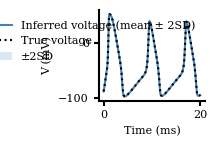

In [42]:
# Set colors
color_low = 'steelblue'
color_high = 'darkorange'

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    # ---------- Low noise figure ----------
    plt.figure(figsize=(5.5/3, 1.5))
    plt.plot(times, mean_traj, color=color_low, linestyle='-', label='Inferred voltage (mean ± 2SD)')
    plt.plot(times, true_outputs[comp], color="black", linestyle=':', label="True voltage")
    plt.fill_between(times,
                 mean_traj - 2*std_traj,
                 mean_traj + 2*std_traj,
                 color=color_low, alpha=0.2, linewidth=0,
                 label='±2SD')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("volt_diagEKF_comp5.svg")

In [ ]:
import pickle
with open("single_branch_bdiag.pkl", "rb") as f:
    data = pickle.load(f)
    outs_bd = data["outs"]

In [ ]:
final_gls_diag = outs_diag['HH_gLeak'][:40,-1]
final_gNas_diag = outs_diag['HH_gNa'][:40,-1]
final_gKs_diag = outs_diag['HH_gK'][:40,-1]

In [ ]:
final_gls_bd = outs_bd['HH_gLeak'][:40,-1]
final_gNas_bd = outs_bd['HH_gNa'][:40,-1]
final_gKs_bd = outs_bd['HH_gK'][:40,-1]

In [21]:
import jax.numpy as jnp
from jax import device_get
import matplotlib.pyplot as plt

# Your 1D arrays (they can already be jnp arrays; if not, wrap with jnp.asarray)
# final_gls_diag, final_gls_EKF, final_gls_bd, final_gls_MSE

datasets = {
    "GLS (diag)": jnp.asarray(final_gls_diag),
    "GLS (EKF)":  jnp.asarray(final_gls_EKF),
    "GLS (BD)":   jnp.asarray(final_gls_bd),
    "GLS (MSE)":  jnp.asarray(final_gls_MSE),
}

# --- Common bins using jax.numpy ---
all_vals = jnp.concatenate([v.ravel() for v in datasets.values()])
nbins = 30
vmin, vmax = jnp.min(all_vals), jnp.max(all_vals)
# Avoid zero width if all values equal
if vmin == vmax:
    vmax = vmin + 1e-12
edges = jnp.linspace(vmin, vmax, nbins + 1)

# --- Hist counts in JAX, then device_get for plotting ---
hist_data = {}
for label, vals in datasets.items():
    counts, _ = jnp.histogram(vals, bins=edges)
    hist_data[label] = device_get(counts)

edges_np = device_get(edges)
widths = edges_np[1:] - edges_np[:-1]
centers = edges_np[:-1]  # use left edges with align='edge'

plt.figure(figsize=(7,4.5))
for i, (label, counts_np) in enumerate(hist_data.items()):
    plt.bar(
        centers,
        counts_np,
        width=widths,
        align="edge",
        alpha=0.45,
        label=label,
        edgecolor="none",
    )

true_gl = 0.0003
plt.axvline(true_gl, linestyle="--", linewidth=2, label=f"True g_l = {true_gl:g}")

plt.xlabel("g_l estimate")
plt.ylabel("Count")
plt.title("Distributions of g_l estimates (JAX hist + matplotlib)")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'final_gls_diag' is not defined

In [ ]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5/3+0.2, 1.3))

    labels = ["MSE", "EKF", "BD", "Diag"]
    data_jax = [
        jnp.asarray(final_gNas_MSE),
        jnp.asarray(final_gNas_EKF),
        jnp.asarray(final_gNas_bd),
        jnp.asarray(final_gNas_diag),
    ]
    data_np = [np.asarray(device_get(x)) for x in data_jax]

    true_gl = 0.12

    bp = ax.boxplot(
        data_np,
        labels=labels,
        patch_artist=True,          # allow facecolor fill
        showfliers=False,           # remove outliers
        meanline=True,              # mean as a line if enabled
        showmeans=False,            # hide mean marker
        boxprops=dict(linewidth=0.6),
        whiskerprops=dict(linewidth=0.6),
        capprops=dict(linewidth=0.6),
        medianprops=dict(linewidth=1.0),
    )

    # Light fills
    for b in bp['boxes']:
        b.set_facecolor((0.7, 0.7, 0.9, 0.5))

    ax.axhline(true_gl, linestyle="--", linewidth=1.0, color="black",
               label=f"True g_l = {true_gl:g}")

    # Add y-axis label
    ax.set_ylabel(r"$g_{Na}$ (S/cm$^2$)")

    ax.legend(loc="best")
    fig.tight_layout()
    fig.savefig("comparison.svg")
    plt.show()

In [ ]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5.5, 1.5), sharey=False)

    method_labels = ["MSE", "EKF", "BD", "Diag"]
    thin = 0.6

    def to_host_list(arrs_jax):
        return [np.asarray(device_get(jnp.asarray(a))) for a in arrs_jax]

    def make_box(ax, data_np, true_val, ylabel=None, title=None, legend_label=None):
        bp = ax.boxplot(
            data_np,
            labels=method_labels,
            patch_artist=True,
            showfliers=False,                # remove outliers
            meanline=True,
            showmeans=False,                 # hide mean marker
            boxprops=dict(linewidth=thin),   # thin box contours
            whiskerprops=dict(linewidth=thin),
            capprops=dict(linewidth=thin),
            medianprops=dict(linewidth=1.0),
        )
        # Light fills
        for b in bp['boxes']:
            b.set_facecolor((0.7, 0.7, 0.9, 0.5))

        # True value line
        ax.axhline(true_val, linestyle="--", linewidth=1.0, color="black",
                   label=legend_label if legend_label else None)

        if ylabel:
            ax.set_ylabel(ylabel)
        if title:
            ax.set_title(title, pad=2)

        # only show legend if we passed a label
        if legend_label:
            ax.legend(loc="best", frameon=False)

    # --- Panel 1: g_l ---
    data_gl = to_host_list([final_gls_MSE, final_gls_EKF, final_gls_bd, final_gls_diag])
    make_box(
        axes[0], data_gl, true_val=0.0003,
        ylabel=r"$g_{L}$ (S/cm$^2$)",
        legend_label=r"True value")

    # --- Panel 2: g_K ---
    data_gk = to_host_list([final_gKs_MSE, final_gKs_EKF, final_gKs_bd, final_gKs_diag])
    make_box(
        axes[1], data_gk, true_val=0.02,
        ylabel=r"$g_{K}$ (S/cm$^2$)")

    # --- Panel 3: g_Na ---
    data_gna = to_host_list([final_gNas_MSE, final_gNas_EKF, final_gNas_bd, final_gNas_diag])
    make_box(
        axes[2], data_gna, true_val=0.12,
        ylabel=r"$g_{Na}$ (S/cm$^2$)")

    fig.tight_layout(w_pad=1.0)
    fig.savefig("comparison_triptych.svg")
    plt.show()

In [ ]:
true_params = Trainer.ref_cond_params
from jax.tree_util import tree_map
idx = 0
inferred_params = tree_map(lambda x: x[idx], outs_bd)
plot_cond_params(params = inferred_params, true_params = true_params)

### Initialization 

In [ ]:
inferred_params

In [ ]:
inferred_params

In [ ]:
import pickle
with open("single_branch_inits.pkl", "rb") as f:
    data = pickle.load(f)
    outs_inits = data["outs"]

In [ ]:
from jax.tree_util import tree_map
idx = 9
inferred_params = tree_map(lambda x: x[2, idx], outs_inits)
plot_cond_params(params = inferred_params, true_params = true_params)

In [ ]:
gK_1 = tree_map(lambda x: x[0, :40, :200], outs_inits)['HH_gK']
gK_3 = tree_map(lambda x: x[1, :40, :200], outs_inits)['HH_gK']
gK_4 = tree_map(lambda x: x[2, jnp.r_[0:9, 10:41], :200], outs_inits)['HH_gK']

In [ ]:
def mean_and_std_over_trials(arr_50xT):
    mean = jnp.mean(arr_50xT, axis=0)  # (T,)
    std  = jnp.std(arr_50xT, axis=0)   # (T,)
    return mean, std

def plot_mean_pm_sd(ax, arr_50xT, iters):
    mean, std = mean_and_std_over_trials(arr_50xT)
    ax.plot(iters, mean)
    ax.fill_between(iters, mean - std, mean + std, alpha=0.25)


T = gK_1.shape[1]          # should be 1000
iters = jnp.arange(T)      # 0..999

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5/3, 1.5))
    plot_mean_pm_sd(ax, gK_1, iters)
    plot_mean_pm_sd(ax, gK_3, iters)
    plot_mean_pm_sd(ax, gK_4, iters)
    
    ax.axhline(0.02,  color='black', linestyle='--', label='True value')
    
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"$g_K$ (S/cm$^2$)")

    # Only show x-ticks at 0 and 200
    ax.set_xlim(0, 200)
    ax.set_xticks([0, 200])
    
    ax.legend() 
    
    fig.tight_layout()
    plt.savefig("different_inits.svg")